<a href="https://colab.research.google.com/github/knobs-dials/wetsuite-dev/blob/main/notebooks/intro/using_dataset_kansspelautoriteit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# (only) in colab, run this first to install wetsuite from (the most recent) source.   For your own setup, see wetsuite's install guidelines.
!pip3 install -U --no-cache-dir --quiet https://github.com/knobs-dials/wetsuite-dev/archive/refs/heads/main.zip


# Purpose of this notebook



To show you around the dataset from the [kansspelautoriteit](https://kansspelautoriteit.nl/)'s [sanctiebesluiten](https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/)

In [2]:
import pprint

import wetsuite.datasets
ks = wetsuite.datasets.load('kansspelautoriteit-sancties-struc')

In [3]:
# how does that dataset describe itself?
print( ks.description )

This is a plaintext form of the set of documents you can find under https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/ as PDFs.

            Since almost half of those PDFs do not have a text stream, this data is entirely OCR'd,
            so expect some typical OCR errors.  The OCR quality seems fairly decent, and some effort was made to remove headers and footers,
            yet there are some leftovers  like _ instead of . and = instead of :


            The data is a fairly nested structure of python objects (or JSON, before it's parsed).
            - .data is a list of cases.

            - each case is a dict, with a 
                - 'name', 
                - 'docs' (a list) 
                - and some extracted information like mentioned money amounts, the apparent date span of the case

            - each document in that mentioned list is is a dict, with keys like
              - 'url' - to the PDF it came from
              - 'status' - from the detail p

## What does the document data look like?

Text in fragments, grouped into pages. 

Yes, these fragments are somewhat clunky to work with.

This is sort of a fact of life if the document doesn't provide text and we have to apply OCR.

We could flatten that to text, but that requires baking even more interpretation than we already do
('more': we already estimate how to remove headers, join and split paragraphs, and section names).

So instead, we show this (creative) work here.
We currently do not figure out whether paragraphs continue from the previous page. 
As the next section illustrates, something like "first letter on a page is lowercase" doesn't always work, 
which argues either for better polishing of this data - or perhaps to give it in even clunkier OCR form where the positions on the page are still there.

In [6]:
cases = ks.data   # Call it what it is.   Type-wise this is a list of case dicts

for case_details in cases:                                # show case's
    print('\n\n === CASE: %s === '%case_details['name'])  # name
    for ck, cv in case_details.items():                   # and metadata
        if ck not in ('name', 'docs'):                    #   (skip some fields)
            print('   %20s %s'%(ck, cv) )

    # List the documents that are part of the case
    print('              DOCUMENTS    (%d of them)'%(len(case_details['docs']),) )
    for doc_dict in case_details['docs']:
        print()
        for dk, dv in doc_dict.items():
            if dk in ('pages',):
                print('   %30s %s'%('#pages', len(dv)) )
            else:
                print('   %30s %s'%(dk, dv) )




 === CASE: Probe Investments Limited === 
             date_range ['2022-12-20', '2022-12-20']
                  money ['1128000', '900000', '600000', '800000', '800000', '1600000', '800000', '600000', '17363089', '17363089', '1128000', '1128000']
                   ecli []
        case_detail_url https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/probe-investments-limited/
              DOCUMENTS    (2 of them)

                              url https://kansspelautoriteit.nl/publish/library/32/15269_01-281-231_sanctiebesluit_probe_investments_limited_ov.pdf
                           #pages 27
                     header_dates ['2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20', '2022-12-20

In [6]:
# For example, the first page  in the first document  of the first case
pprint.pprint( cases[0]['docs'][0]['pages'][0] )

{'date_range': ['2022-12-20', '2022-12-20'],
 'docs': [{'header_dates': ['2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '2022-12-20',
                            '20

## Flattening to text

In [ ]:
# Example: flatten documents into plain text files.
import re

files = [] # Our goal: a list of  (filename, singlestring)  tuples

for case_i, case in enumerate( cases ):   # enumerate helps numbering, e.g. enumerate(['q','r'])  yields  (0, 'q'),  (1, 'r')
    for doc_i, doc in enumerate( case['docs'] ):

        # figure out a descriptive filename
        case_safename = re.sub( '[^A-Za-z0-9\s]','', case['name'] )    # remove anything other than basic alphanumeric, so that it's safe to put in a file name
        doc_name      = wetsuite.helpers.format.url_basename(doc['url']).rsplit('.')[0] # the split takes off the .pdf
        filename      = "case%04d_doc%02d__%s__%s.txt"%(case_i, doc_i, case_safename, doc_name) # the numbering also makes filenames unique

        doc_text = [] # we collect document content here

        for page in doc['pages']:
            for par_i, par in enumerate( page['body_text'] ):
                # par is text, so we mostly just care to do that final 'doc_text.append( par )'

                # ...but here we try to estimates whether we should put in an empty line or not - whether the first text on a page continues a paragraph from the previous page
                if par_i == 0: # first text fragment on a page
                    first_character = par.strip()[0] # currently not very cleverly:
                    if first_character in '0123456789' or first_character != first_character.lower(): # assume a numbered thing is to be separated,   and not-lowercase the same (not always true) 
                        doc_text.append( '\n\n' ) # add empty line
                    else:
                        doc_text.append( '\n' ) # same paragraph, but let's put it on a new line  (you may care to change this, depending on how you consume that text)
                else: # all but the first paragraph: alway add an empty line
                    doc_text.append( '\n\n' ) # new paragraph

                doc_text.append( par )

        files.append( (filename, ''.join(doc_text)) )

In [ ]:
# if doing this locally, you could write a few hundred .txt files        
for filename, content_string in files:
    print("WRITING %r"%filename)
    with open(filename, mode='w', encoding='utf8') as txtfile:
        txtfile.write( content_string )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# If doing this in google colab, you may want to fetch those files as a single archive
import zipfile
import google.colab.files

with zipfile.ZipFile('kansspel_txt.zip', 'w') as zip:
    for filename, content_string in files:
        zip.writestr( filename , content_string.encode('utf8'), compress_type=zipfile.ZIP_DEFLATED, compresslevel=5 )

google.colab.files.download('kansspel_txt.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Something a little more interesting

For a short example, let's make a word cloud for each case, for some idea about the focus of each case.

We use spacy to extract only the nouns, and maybe verbs, to make that word cloud less messy.

In [ ]:
# spacy itself was installed as a dependency of wetsuite,  but we do not necessarily have a language model to apply to the text:
!python3 -m spacy download nl_core_news_md

In [ ]:
import spacy
dutch = spacy.load('nl_core_news_md')

CASE: Toto Online B.V.
  01_278_071_15091_sanctiebesluit_toto_ov.pdf
  01_278_082_ov_openbaarmakingsbesluit_woo_15091.pdf
  2204 words


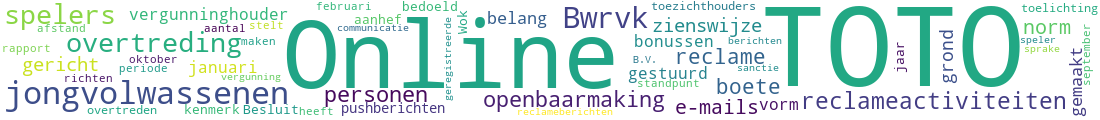


--------------------------------------------------------------------------------
CASE: Nationale Posctode Loterij N.V.
  sanctiebesluit_npl.pdf
  openbaarmakingsbesluit_npl.pdf
  2344 words


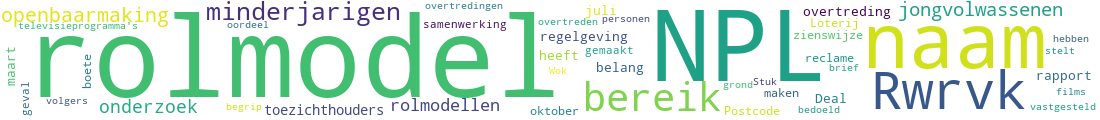


--------------------------------------------------------------------------------
CASE: M.K.C Limited
  20220823_01_265_505_-_besluit_last_onder_dwangsom_ov.pdf
  20220823_01_265_507_-_besluit_openbaarmaking_ov.pdf
  1589 words


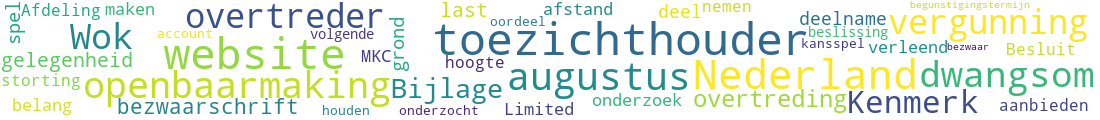


--------------------------------------------------------------------------------
CASE: L.C.S Limited
  20220817_01_265_500_-_besluit_lod_sons-of-slots_ov.pdf
  20220817_01_265_499_-_besluit_openbaarmaking_ov.pdf
  1590 words


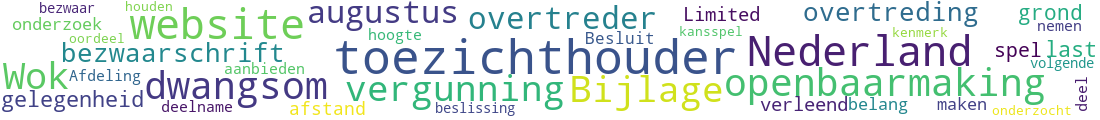


--------------------------------------------------------------------------------
CASE: Gammix Limited
  20220707_01_270_078_-_lod_gammix_ov.pdf
  20220707_01_270_081_-_besluit_openbaarmaking_gammix_ov.pdf
  2029 words


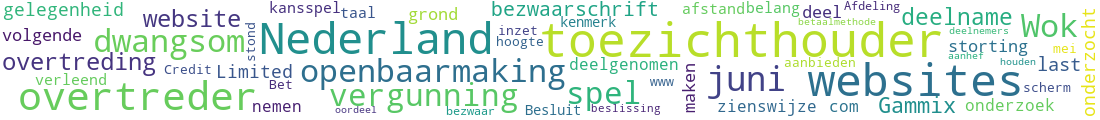


--------------------------------------------------------------------------------
CASE: Red Ridge Marketing
  20220412_01_263_969_besluit_lod_ov_1.pdf
  20220412_01_263_968_besluit_openbaarmaking_wob_ov_1.pdf
  1664 words


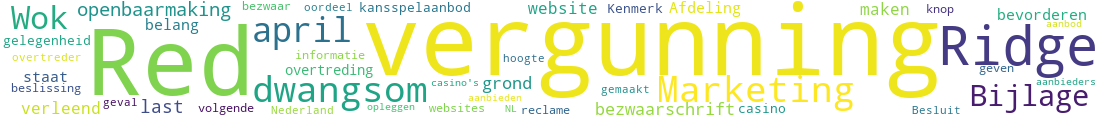


--------------------------------------------------------------------------------
CASE: Performing Media Limited
  last_onder_dwangsom_performing_media_limited.pdf
  besluit_tot_openbaarmaking_performing_media_limited.pdf
  1787 words


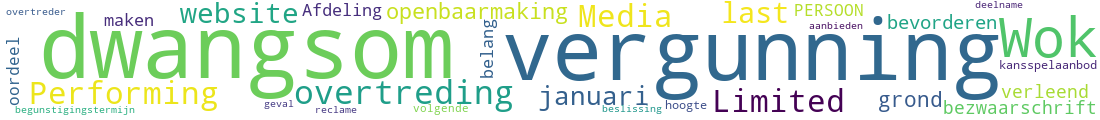


--------------------------------------------------------------------------------
CASE: Linkerik B.V.
  besluit_last_onder_dwangsom_14508.pdf
  besluit_openbaarmaking_14508.pdf
  1559 words


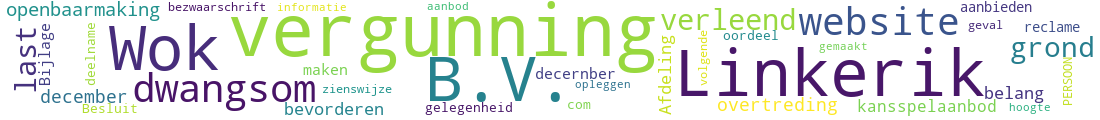


--------------------------------------------------------------------------------
CASE: Onlinecasinobonus.nl
  last_onder_dwangsom_onlinecasinobonus_nl.pdf
  besluit_openbaarmaking_onlinecasinobonus_nl.pdf
  2048 words


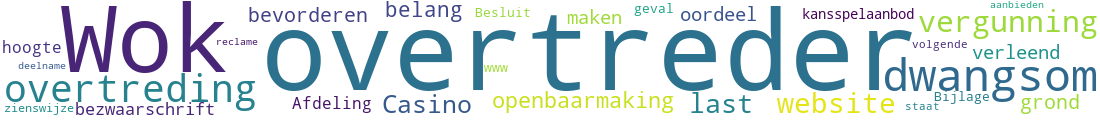


--------------------------------------------------------------------------------
CASE: LCB CORP
  lcb_corp_lod_20211213_01_252_632_lod_nl_lcb_org_ov.pdf
  lcb_corp_besluit_openbaarmaking_20211213_01_252_633.pdf
  1562 words


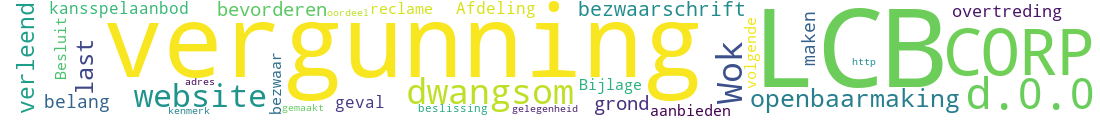


--------------------------------------------------------------------------------
CASE: Casinoscout.nl
  casinoscout_nl_besluit_openbaarmaking_ov.pdf
  casinoscout_nl_lod.pdf
  1318 words

--------------------------------------------------------------------------------
CASE: Online Casino Ground ltd
  last_onder_dwangsom_online_casino_ground_ltd.pdf
  besluit_openbaarmaking_online_casino_ground_ltd.pdf
  1352 words

--------------------------------------------------------------------------------
CASE: Slots Dev
  last_onder_dwangsom_slots_dev.pdf
  besluit_openbaarmaking_slots_dev.pdf
  1337 words

--------------------------------------------------------------------------------
CASE: Tipico Co. Ltd
  besluit_tipico_openbaar.pdf
  openbaarmakingsbesluit_tipico_openbaar.pdf
  2867 words

--------------------------------------------------------------------------------
CASE: BSB Shop
  besluit_last_onder_dwangsom_bsb_shop.pdf
  besluit_openbaarmaking_bsb_shop.pdf
  1238 words

------------

In [ ]:
import textwrap, random, re
import wetsuite.helpers.format
import wetsuite.extras.word_cloud

stop_mixed = []
stop_mixed.extend( wetsuite.extras.word_cloud.stopwords_nl ) # shouldn't be as necessary when you use the 'only nouns' code, but in case you don't
stop_mixed.extend( 'Kansspelautoriteit kansspelen artikel lid Wet raad bestuur besluit'.split() ) # extra stopwords - nouns that we decide are common to all cases and less interesting to see

def show_wordcloud(words):
    counts = wetsuite.extras.word_cloud.count_normalized( words, stopwords=stop_mixed )
    im = wetsuite.extras.word_cloud.wordcloud_from_freqs( counts, 1100, 120 )
    display( im )   # note: display() exists in the context of IPython notebooks.  Outside of notebooks you would probably im.save() instead.


# only show wordcloud image for first few cases, to keep this demo notebook size down  (the rest are still parsed, but only for the final word count)
num_wordcloud_cases = 10

num_cases, num_docs, num_pages, num_pars, num_words = 0, 0, 0, 0, 0

for case_i, case in enumerate( cases ) :
    num_cases += 1
    print( 'CASE: %s'%case['name'] )
    words = [] # collects interesting words for a case
    for doc in case['docs']:
        num_docs += 1
        print( '  %s'%wetsuite.helpers.format.url_basename(doc['url']) )
        for page in doc['pages']:
            num_pages += 1
            for par in page['body_text']:
                num_pars += 1
                #for line in textwrap.wrap( par ):
                #    print(line)
                #print()
                parsed = dutch( par )
                for token in parsed:
                    num_words += 1
                    if token.pos_ in ('NOUN','PROPN', 'VERB'):
                        words.append( token.text )

    print( '  %d words'%(len(words))  )
    if case_i < num_wordcloud_cases: 
        show_wordcloud( words )
    print()
    print('-'*80)


print( '\n\nTotal number of   cases:%d  documents:%d   pages:%d   text fragments:%d   words:%d'%( num_cases, num_docs, num_pages, num_pars, num_words) )